In [89]:
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
import math
from pandas import Series
from sklearn.metrics import accuracy_score
from scipy.stats import kurtosis
from scipy.signal import hilbert
from scipy.fftpack import fft
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import xgboost as xgb 
from sklearn.metrics import accuracy_score,classification_report

# 1 Data preprocessing

## 1.1 row_data load / row data resampling(50%) 

In [99]:
root = '/content/drive/MyDrive/Colab_Notebooks/CWRU/data_1/'
str_name1 = 'cwru_'
str_name2 = 'CWRU_'

for i in range(0, 10):
    '''data load'''
    data = pd.read_csv(root + 'CWRU_' + str(i) + '.csv',engine = 'python')
    data_name = str_name1 + str(i)   # print(data_name)  -- cwru_1, cwru_2...
    data_name = data.values   
# print(cwru_0)  -- (m<采样点数> x 4列<三个维度+label>)
# print(cwru_0.shape)  -- (483903, 4)
  
    '''data resampling'''
    sam_name = str_name2 + str(i)
    sam_name = []   
    # print(sam_name)  # [] [] []...
    row_array = np.arange(data_name.shape[0])
    # print(row_array)  -- [     0      1      2 ... 483900 483901 483902]

    k = 0
    for j in range((int)(data_name.shape[0] / 500) - 1):     # 以50%（500/1000）重采样生成的样本数
        CWRU_ = data_name[row_array[k : k + 1000]]           # 1000个点生成一个样本
        sam_name.append(CWRU_)
        k += 500
    print("----------------")
    sam_name = np.array(sam_name)
    print(sam_name.shape)
    # print(CWRU_0.shape)  -- (966, 1000, 4)    # 966个样本， 每个样本中含1000个采样点， 每个采样点是4个特征（3+1
    

----------------
(966, 1000, 4)
----------------
(241, 1000, 4)
----------------
(243, 1000, 4)
----------------
(242, 1000, 4)
----------------
(242, 1000, 4)
----------------
(242, 1000, 4)
----------------
(242, 1000, 4)
----------------
(243, 1000, 4)
----------------
(243, 1000, 4)
----------------
(242, 1000, 4)


## 1.2 tools

### 1.2.1 Feature extract(4+8)

In [10]:
''' 频域部分特征转换 '''

#包络谱最大幅值处的频率
def maxf_in_env_spectrum(data, fs):  #data为1000采样点的某一原始特征组织的一维array
    T = 1/fs
    N = len(data)
    analytic_signal = hilbert(data)
    am_enve = np.abs(analytic_signal).reshape(N,)              
    yf = fft(am_enve - np.mean(am_enve))
    y_envsp = 2.0/N * np.abs(yf[0:N//2]).reshape(N//2,1) 
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # 返回最大幅值的频率
    maxf = xf[np.argwhere(y_envsp == np.max(y_envsp))[0][0]]
    return  maxf


#对信号的直方图计算  为了计算信号幅值中位数处的概率密度估计
def hist_for_entropy(s):
        s = np.ravel(s)
        N = len(s)
        s_max = np.max(s)
        s_min = np.min(s)
        delt = (s_max - s_min) / N
        c_0 = s_min - delt / 2
        c_N = s_max + delt / 2
        ncell = int(np.ceil(np.sqrt(N)))

        # c = f(s)
        c = np.round((s - c_0) / (c_N - c_0) * ncell + 1/2)

        # 计算分组数组出现的频次
        res = np.zeros(ncell)
        for i in range(0, N):
            ind = int(c[i])
            if ind >= 1 and ind <= ncell:
                res[ind-1] = res[ind-1] + 1

        return res, s_min, s_max, ncell
    
#一维序列信号幅值中位数处的概率密度估计
def pdf_for_median_am(s):
        N = len(s)
        res, s_min, s_max, ncell = hist_for_entropy(s)
        # 归一化的到概率密度
        pdf = res / N / (s_max - s_min) * ncell
        
        # 幅值中位数 映射 到直方图的组号
        delt = (s_max - s_min) / N
        c_min = s_min - delt / 2
        c_max = s_max + delt / 2
        
        s_median = np.median(s)
        s_median_icell = int(np.round((s_median - c_min) / (c_max - c_min) * ncell + 1/2))
        
        return  pdf[s_median_icell]

#一维序列的香农信号熵
def shannom_entropy_for_hist(s):
        h,s_min, s_max, ncell = hist_for_entropy(s)
        # 无偏估计
        h = h[h!=0]
        N = np.sum(h)
        estimate = -np.sum(h*np.log(h)) / N
        sigma = np.sum(h*np.log2(h)**2)    
        sigma = np.sqrt((sigma/N - estimate**2) / (N - 1))
        estimate = estimate + np.log(N) + np.log((s_max-s_min)/ncell)
        nbias = -(ncell-1)/(2*N)
        estimate = estimate - nbias
        return estimate

In [11]:
''' 特征提取 '''

# 第三类 FE
cwru_1_FE = np.delete(cwru_1, [0,2], axis=1)
cwru_1_FE = np.delete(cwru_1_FE, -1, axis=1)
# print(cwru_1_DE.shape)
# print(cwru_1_DE)
FE_1_1 = cwru_1_FE[0:1000]
# print(cwru_1_DE_1.shape)

fs = 12000
def feature(data, p1, p2,fs):
    sum = 0
    for i in range(p1, p2):
        sum += math.sqrt(abs(data[i]))
    #最大值
    max_ = data[p1:p2].max()
    #均值
    mean_ = data[p1:p2].mean()
    #绝对值
    abs_ = abs(data[p1:p2])
    #方差
    var_ = data[p1:p2].var()
    #标准差
    std_ = data[p1:p2].std()
    #均方根
    rms_ = math.sqrt(pow(mean_, 2) + pow(std_, 2))
    
    xx=[x[0] for x in data]
    s = pd.Series(xx)
    # 峭度
    kurt_ = s.kurt()
    #print(kurt_EF)
    # 偏度
    skew_ = s.skew()  
    
    # 波形因子
    form_ = rms_ / (abs_.mean())
    # 峰值因子
    par_ = max_ / rms_
    # 脉冲因子
    impulse_ = max_ / (abs_.mean())
    # 裕度因子
    yudu_ = max_ / pow((sum / (p2 - p1)), 2)
    # 输入reshape成一维，用于后续频域分析
    data_s = data.ravel()
    # 包络谱最大幅值处的频率
    maxf_ = maxf_in_env_spectrum(data_s,fs)
    # 一维序列信号幅值中位数处的概率密度估计
    pdf_ = pdf_for_median_am(data_s)
    # 一维序列的香农信号熵
    entropy_ = shannom_entropy_for_hist(data_s)
    
    feature_list = {"mean": mean_, "var": var_, "rms":rms_, 
                    "kurt":kurt_, "skew":skew_, "form":form_,
                    "par":par_, "impulse":impulse_, "yudu":yudu_,
                    "maxf":maxf_, "entropy":entropy_, "pdf":pdf_}
    return feature_list

# 用第一类cwru_1的第一列 FE测试
feature(FE_1_1, 1, 1000,fs)

{'entropy': -0.5706768585895942,
 'form': 1.2346087309932834,
 'impulse': 3.6626719922256763,
 'kurt': -0.18708305756403298,
 'maxf': 156.312625250501,
 'mean': 0.004968823943943942,
 'par': 2.9666661998080444,
 'pdf': 2.3336084564390505,
 'rms': 0.1371573249549707,
 'skew': -0.035317973590993916,
 'var': 0.01878744257741752,
 'yudu': 4.2784956673448935}

### 1.2.2 Data to Samples

In [12]:
''' 1000采样点生成一个样本 '''

p1 = 1
p2 = 1000
def data_to_samples(data_mkup_thousand):
    number = 0
    for each_matrix in data_mkup_thousand:
        label_of_sample = each_matrix[0][-1]
        BA_of_each = each_matrix[:,0].reshape(-1,1)    #采样矩阵reshape成三个单列
        DE_of_each = each_matrix[:,1].reshape(-1,1)
        FE_of_each = each_matrix[:,2].reshape(-1,1)
        
#         # 每个采样矩阵BA特征提取
#         single_of_BA = []                          #p2个采样点提取出的一个样本列表
#         dict_BA = feature(BA_of_each, p1, p2,fs)
#         for i in dict_BA.values():
#             single_of_BA.append(i)
#         single_of_BA.append(label_of_sample)
#         single_of_BA = np.array(single_of_BA).reshape(1,-1)  #转为array
        
        # 每个采样矩阵对DE特征提取
        single_of_DE = []                        #p2个采样点提取出的一个样本列表
        dict_DE = feature(DE_of_each, p1, p2,fs)
        for j in dict_DE.values():
            single_of_DE.append(j)
        single_of_DE.append(label_of_sample)
        single_of_DE = np.array(single_of_DE).reshape(1,-1)   #转为array
            
        # 每个采样矩阵对FE特征提取
        single_of_FE = []   #p2个采样点提取出的一个样本列表
        dict_FE = feature(FE_of_each, p1, p2,fs)
        for k in dict_FE.values():
            single_of_FE.append(k)
        single_of_FE.append(label_of_sample)
        single_of_FE = np.array(single_of_FE).reshape(1,-1)  #转为array
        
        sample_matrix = np.concatenate((single_of_DE,single_of_FE),axis = 0).reshape(1,2,-1)   #样本矩阵     
        #sample_matrix = np.concatenate((single_of_BA,single_of_DE,single_of_FE),axis = 0).reshape(1,3,-1)  考虑BA情况
        
        if number == 0:
             matrix_to_samples = sample_matrix
        else:
             matrix_to_samples = np.concatenate((matrix_to_samples,sample_matrix),axis = 0)
        number = number + 1
    return matrix_to_samples

### 1.2.3 Data Partitioning & Shuffling

In [100]:
'''划分数据集：train, eval, test'''

def datasplit(data):
    total = data.shape[0]
    each = total//10
    indexlist = list(range(total))   #索引列表
    random.shuffle(indexlist)
    train_indice = indexlist[:7*each]
    eval_indice = indexlist[7*each:9*each]
    test_indice = indexlist[9*each:]
    return data[train_indice],data[eval_indice],data[test_indice]

In [101]:
''' 打乱数据 '''

def shuffle(data,label):    
    index = [i for i in range(len(data))] 
    random.shuffle(index) 
    data = data[index]
    label = label[index] 
    return data, label

## 1.3 Sample Generation & Dataset Partition

In [102]:
''' 生成10类样本 '''

matrix_to_samples_0 = data_to_samples(CWRU_0)
matrix_to_samples_1 = data_to_samples(CWRU_1)
matrix_to_samples_2 = data_to_samples(CWRU_2)
matrix_to_samples_3 = data_to_samples(CWRU_3)
matrix_to_samples_4 = data_to_samples(CWRU_4)
matrix_to_samples_5 = data_to_samples(CWRU_5)
matrix_to_samples_6 = data_to_samples(CWRU_6)
matrix_to_samples_7 = data_to_samples(CWRU_7)
matrix_to_samples_8 = data_to_samples(CWRU_8)
matrix_to_samples_9 = data_to_samples(CWRU_9)

In [103]:
''' 划分train,eval,test '''

cwru_0_train,cwru_0_eval,cwru_0_test = datasplit(matrix_to_samples_0)
cwru_1_train,cwru_1_eval,cwru_1_test = datasplit(matrix_to_samples_1)
cwru_2_train,cwru_2_eval,cwru_2_test = datasplit(matrix_to_samples_2)
cwru_3_train,cwru_3_eval,cwru_3_test = datasplit(matrix_to_samples_3)
cwru_4_train,cwru_4_eval,cwru_4_test = datasplit(matrix_to_samples_4)
cwru_5_train,cwru_5_eval,cwru_5_test = datasplit(matrix_to_samples_5)
cwru_6_train,cwru_6_eval,cwru_6_test = datasplit(matrix_to_samples_6)
cwru_7_train,cwru_7_eval,cwru_7_test = datasplit(matrix_to_samples_7)
cwru_8_train,cwru_8_eval,cwru_8_test = datasplit(matrix_to_samples_8)
cwru_9_train,cwru_9_eval,cwru_9_test = datasplit(matrix_to_samples_9)

cwru_train = np.concatenate((cwru_0_train,cwru_1_train,cwru_2_train,cwru_3_train,cwru_4_train,cwru_5_train,cwru_6_train,cwru_7_train,cwru_8_train,cwru_9_train),axis = 0)
cwru_eval = np.concatenate((cwru_0_eval,cwru_1_eval,cwru_2_eval,cwru_3_eval,cwru_4_eval,cwru_5_eval,cwru_6_eval,cwru_7_eval,cwru_8_eval,cwru_9_eval),axis = 0)
cwru_test = np.concatenate((cwru_0_test,cwru_1_test,cwru_2_test,cwru_3_test,cwru_4_test,cwru_5_test,cwru_6_test,cwru_7_test,cwru_8_test,cwru_9_test),axis = 0)
print(cwru_train.shape)
print(cwru_eval.shape)
print(cwru_test.shape)

(2184, 2, 13)
(624, 2, 13)
(338, 2, 13)


In [105]:
'''打乱'''

X_train_DE, y_train_DE =  shuffle(cwru_train[:,0,0:12], cwru_train[:,0,12])
X_eval_DE, y_eval_DE =  shuffle(cwru_eval[:,0,0:12], cwru_eval[:,0,12])
X_test_DE, y_test_DE =  shuffle(cwru_test[:,0,0:12], cwru_test[:,0,12])

X_train_FE, y_train_FE =  shuffle(cwru_train[:,1,0:12], cwru_train[:,1,12])
X_eval_FE, y_eval_FE =  shuffle(cwru_eval[:,1,0:12], cwru_eval[:,1,12])
X_test_FE, y_test_FE =  shuffle(cwru_test[:,1,0:12], cwru_test[:,1,12])

# 2 Model & Train & Test

已经划分好了数据集：
* DE: *`X_train_DE / y_train_DE`  `X_eval_DE / y_eval_DE`  `X_test_DE / y_test_DE`*
* FE: *`X_train_FE / y_train_FE`  `X_eval_FE / y_eval_FE`  `X_test_FE / y_test_FE`*

## 2.1 KNN

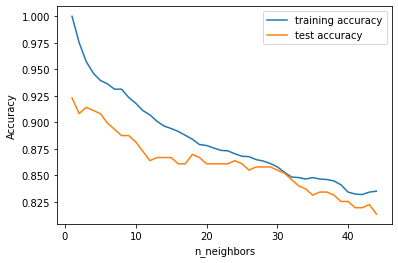

In [18]:
''' knn训练 '''
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,45)

for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors)    #实例化KNN模型
    knn.fit(X_train_DE, y_train_DE)      #放入训练数据进行训练
    # print(knn.predict(cwru_eval[:,:-1]))           #打印预测内容
    # print(cwru_test[:3])     #实际标签
    training_accuracy.append(knn.score(X_train_DE, y_train_DE))
    #print(knn.score(cwru_train[:,0,0:12],cwru_train[:,0,12]))
    test_accuracy.append(knn.score(X_test_DE, y_test_DE))
    #print("k={}: accuracy: {:.3f}% ".format(n_neighbors,knn.score(X_test_DE, y_test_DE)*100))
#max_index = eval_accuracy.index(max(eval_accuracy))
#print(max_index, max(eval_accuracy))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend()

#X_test_DE.shape

In [19]:
''' 混淆矩阵绘制 '''

def Confusion_Matrix(pre, fact):
    classes = list(set(fact))
    classes.sort()
    confusion = confusion_matrix(pre, fact)
    plt.imshow(confusion, cmap=plt.cm.coolwarm)
    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)

    plt.colorbar()

    plt.xlabel('pre')
    plt.ylabel('fact')
    # 显示数据，直观些
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.show()

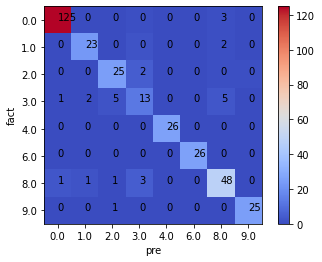

In [112]:
# knn混淆矩阵
knn = KNeighborsClassifier(n_neighbors=4)    #实例化KNN模型
knn.fit(X_train_DE, y_train_DE)      #放入训练数据进行训练
pred_knn = knn.predict(X_test_DE)
#print(prediction)
#print(y_test_DE)     #实际标签
Confusion_Matrix(pred_knn, y_test_DE)

## 3.2 SVM
* SVM主要有两个参数：C（惩罚系数）、kernal（核函数）
1. 核函数（线性核、高斯核、多项式核）：
  * 若要实现非线性SVM模型，需要找到一个核函数把**特征空间映射到高维空间，使样本在高维线性可分**
  * 核技巧：解决了映射后高维空间中样本距离计算，但又不显式展示出映射函数
2. 惩罚系数：
  * 惩罚因子可以理解为调节优化方向中两个指标（间隔大小/分类准确度）偏好的权重：C越大，偏重准确率；C越小，偏重噪声容忍度

* 结果：线性核效果最好，其他两种效果很差，为什么呢？

linear kernel
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       0.96      0.96      0.96        25
         2.0       0.79      0.85      0.82        27
         3.0       0.70      0.54      0.61        26
         4.0       1.00      1.00      1.00        26
         6.0       1.00      1.00      1.00        26
         8.0       0.90      0.96      0.93        54
         9.0       1.00      1.00      1.00        26

    accuracy                           0.94       338
   macro avg       0.92      0.91      0.91       338
weighted avg       0.94      0.94      0.94       338



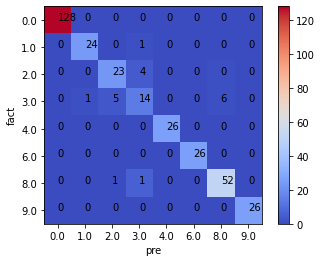

------------------------------
RBF kernel
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74       128
         1.0       0.00      0.00      0.00        25
         2.0       0.00      0.00      0.00        27
         3.0       0.20      0.04      0.06        26
         4.0       0.29      1.00      0.45        26
         6.0       0.00      0.00      0.00        26
         8.0       0.50      0.02      0.04        54
         9.0       1.00      0.96      0.98        26

    accuracy                           0.54       338
   macro avg       0.32      0.38      0.28       338
weighted avg       0.42      0.54      0.40       338



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


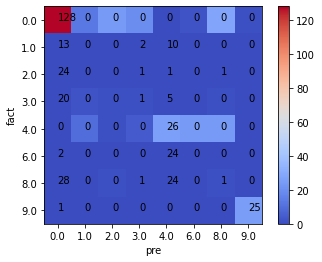

------------------------------
polynomial kernel
              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55       128
         1.0       0.00      0.00      0.00        25
         2.0       0.00      0.00      0.00        27
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        26
         6.0       0.00      0.00      0.00        26
         8.0       0.00      0.00      0.00        54
         9.0       0.00      0.00      0.00        26

    accuracy                           0.38       338
   macro avg       0.05      0.12      0.07       338
weighted avg       0.14      0.38      0.21       338



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


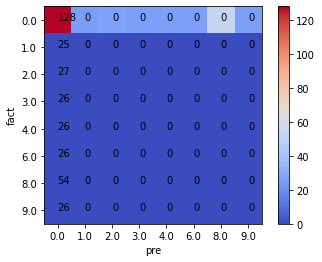

------------------------------


In [111]:
lin_svc = svm.SVC(kernel='linear').fit(X_train_DE, y_train_DE)
rbf_svc = svm.SVC(kernel='rbf').fit(X_train_DE, y_train_DE)
poly_svc = svm.SVC(kernel='poly').fit(X_train_DE, y_train_DE)

title = ['linear kernel',
          'RBF kernel',
          'polynomial kernel']

for i, model in enumerate((lin_svc, rbf_svc, poly_svc)):
    print(title[i])
    pred_svm = model.predict(X_test_DE)
    print(classification_report(y_test_DE, pred_svm))
    Confusion_Matrix(pred_svm, y_test_DE)
    print("------------------------------")

## 3.3 XGboost

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       0.96      0.96      0.96        25
         2.0       0.87      0.96      0.91        27
         3.0       0.91      0.77      0.83        26
         4.0       1.00      1.00      1.00        26
         6.0       1.00      1.00      1.00        26
         8.0       0.98      1.00      0.99        54
         9.0       1.00      1.00      1.00        26

    accuracy                           0.98       338
   macro avg       0.96      0.96      0.96       338
weighted avg       0.98      0.98      0.98       338



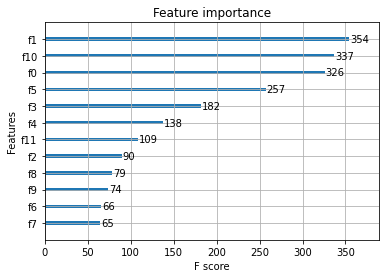

In [107]:
''' XGboost训练 '''
# 算法参数
params = {
    'booster': 'gbtree',             # 基础模型：'决策树 '
    'objective': 'multi:softmax',    # 目标： '多分类：softmax'
    'num_class': 10,                 # 类别个数： ' 10 '    
    'gamma': 0.1,                    # min_split_loss
    'max_depth': 6,                  # 树深 ： 该值越大，模型越复杂
    'lambda': 2,                     # L2正则化权重
    'subsample': 0.7,                # 构建每棵树对样本采样率
    'colsample_bytree': 0.75,        # 特征采样率
    'min_child_weight': 3,           # 节点分裂阈值
    'eta': 0.1,                      # 学习率
}

dtrain = xgb.DMatrix(X_train_DE, y_train_DE)

model = xgb.XGBClassifier(**params)
model.fit(X_train_DE, y_train_DE)
pred_xgboost = model.predict(X_test_DE)
print(classification_report(y_test_DE, pred_xgboost))

# 特征重要性图表
xgb.plot_importance(model)

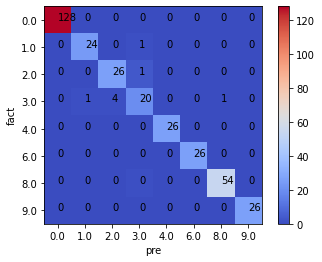

In [108]:
# XGboost混合矩阵
Confusion_Matrix(pred_xgboost, y_test_DE)